# **Vanilla Autoencoder:**
# Here, the encoder and decoder are typically composed of fully connected layers(nn.Linear in Pytorch) without Convolutional layers (nn.Conv2d in Pytorch).

# This architecture is used for encoding and decoding data in a lower-dimensional space. The encoder part compresses the input data into a lower-dimensional representation, and the decoder part reconstructs the original input data from this representation.
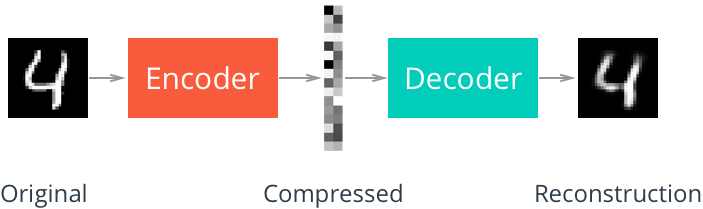

# Import required Libraries

In [1]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
from torchsummary import summary

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np

torch.manual_seed(1)    # reproducible

# Set up device

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Defining Hyperparameters

In [3]:
EPOCH = 10
BATCH_SIZE = 64
LR = 0.005
NUMBER_OF_TEST_IMAGE = 5

# Load MNIST digits dataset

In [4]:
train_data = torchvision.datasets.MNIST(
    root='/content/',
    train=True,
    transform=torchvision.transforms.ToTensor(),
    # Converts PILImage or numpy.ndarray to torch.FloatTensor of shape (C x H x W)
    # and normalize in range [0.0 to 1.0]

    download=True
)

train_loader = Data.DataLoader(dataset=train_data,
                               batch_size=BATCH_SIZE,
                               shuffle=True)

# Let's view one sample image from train data

torch.Size([60000, 28, 28])
torch.Size([60000])


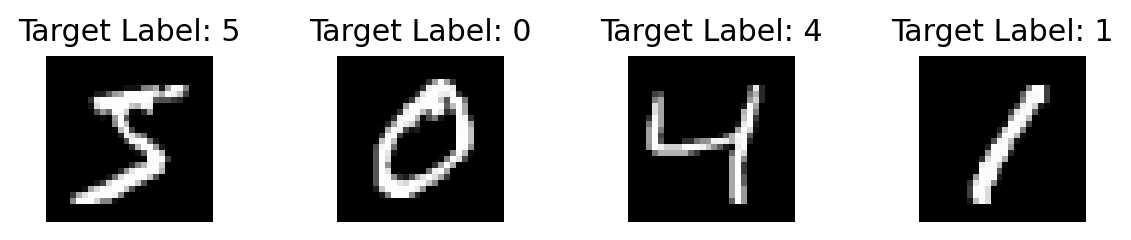

In [5]:
print(train_data.data.size())
print(train_data.targets.size())

fig, axes = plt.subplots(1,4, figsize=(8,1.2), dpi=180)
for i in range(4):
    axes[i].imshow(train_data.data[i].numpy(), cmap='gray')
    axes[i].set_title(f"Target Label: {train_data.targets[i]}")
    axes[i].axis('off')
plt.show()

# Design Model

In [6]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(in_features=28*28, out_features=128),
            nn.Tanh(),          # (e^x - e^(-x)) / (e^x + e^(-x))
            nn.Linear(in_features=128, out_features=64),
            nn.Tanh(),
            nn.Linear(in_features=64, out_features=12),
            nn.Tanh(),
            nn.Linear(12, 3)    # compress to 3 features which can be visualized in plt
        )

        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.Tanh(),
            nn.Linear(12, 64),
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()        # compress to a range(0, 1)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# View model summary

In [7]:
autoencoder = AutoEncoder()

autoencoder.to(device)

summary(model=autoencoder, input_size=(1, 28*28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 128]         100,480
              Tanh-2               [-1, 1, 128]               0
            Linear-3                [-1, 1, 64]           8,256
              Tanh-4                [-1, 1, 64]               0
            Linear-5                [-1, 1, 12]             780
              Tanh-6                [-1, 1, 12]               0
            Linear-7                 [-1, 1, 3]              39
            Linear-8                [-1, 1, 12]              48
              Tanh-9                [-1, 1, 12]               0
           Linear-10                [-1, 1, 64]             832
             Tanh-11                [-1, 1, 64]               0
           Linear-12               [-1, 1, 128]           8,320
             Tanh-13               [-1, 1, 128]               0
           Linear-14               [-1,

# Defining Optimizer and loss function

In [8]:
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
loss_function = nn.MSELoss()
# MSE LOSS: because we need to minimize loss between pixel values of actual image and decoded image

# Model Training


Epoch: 0 | Step: 0  | Train Loss: 0.23


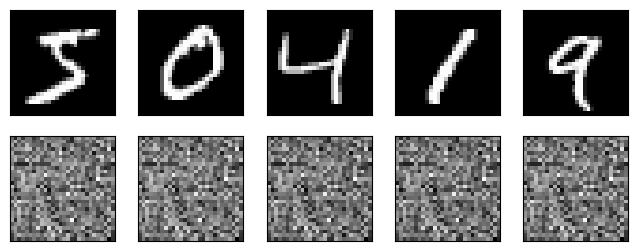


Epoch: 0 | Step: 500  | Train Loss: 0.06


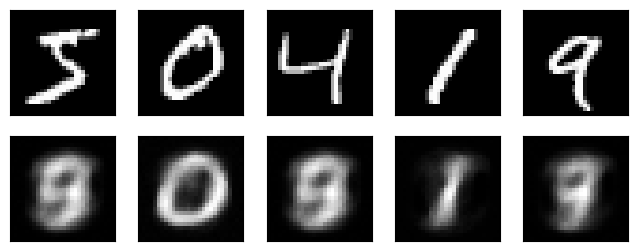


Epoch: 5 | Step: 0  | Train Loss: 0.04


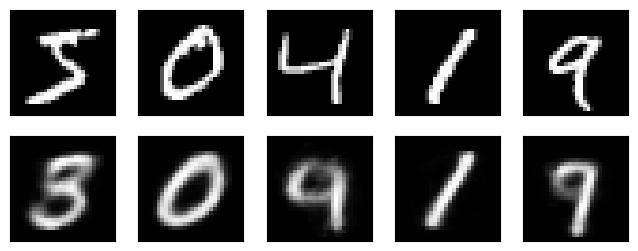


Epoch: 5 | Step: 500  | Train Loss: 0.04


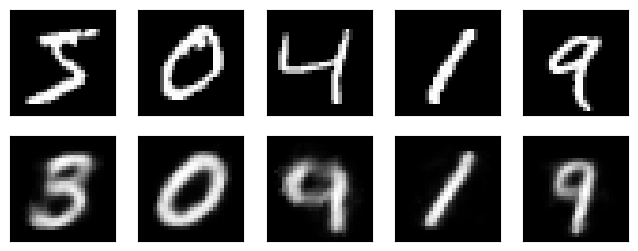


Epoch: 9 | Step: 0  | Train Loss: 0.03


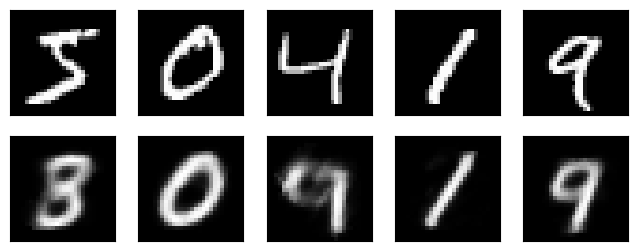


Epoch: 9 | Step: 500  | Train Loss: 0.03


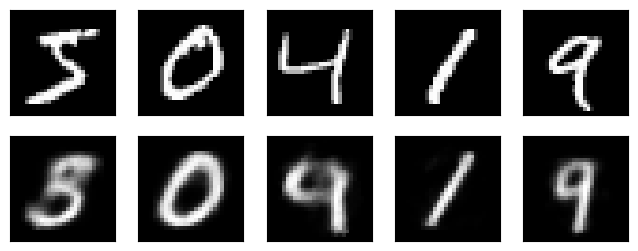

In [9]:
# original data (first row) for viewing
view_original_data = train_data.data[ : NUMBER_OF_TEST_IMAGE].view(-1, 28*28).type(torch.FloatTensor)/255.
view_original_data.requires_grad = True
view_original_data = view_original_data.to(device)

for epoch in range(EPOCH):  # 10 epochs
    for step, (x, y) in enumerate(train_loader):
        b_x = x.view(-1, 28*28).requires_grad_(True)    # batch x, shape=(batch, 28*28)
        b_x = b_x.to(device)
        """

        'b_y' viz. 'batch_y', considering 'INPUT_IMAGE (pixel values)' itself as our TRUTH VALUES,
        we will pass 'b_y' to loss_function, in order to minimize error between...
        'DECODED IMAGE PIXEL VALUES' and 'TARGET IMAGE PIXEL VALUES'.

        """
        b_y = x.view(-1, 28*28).requires_grad_(True)    # batch y, shape=(batch, 28*28)
        b_y = b_y.to(device)

        # passing b_x to the created instance of our model
        encoded, decoded = autoencoder(b_x)

        # passing decoded image and TARGET IMAGE to loss function
        loss = loss_function(decoded, b_y)  # MSELoss() function

        optimizer.zero_grad()   # clear gradients for this training step
        loss.backward()         # perform back-propagation
        optimizer.step()        # apply gradients

        """

        show original and decoded image after 500 steps starting from 0 (0th step output will be printed),
        and
        at 0th, 5th and 9th epoch.

        """
        if step % 500 == 0 and epoch in [0, 5, EPOCH-1]:
            print(f"\nEpoch: {epoch} | Step: {step}  | Train Loss: {loss.item():.2f}")

            # plotting decoded image (second row)
            _, decoded_data = autoencoder(view_original_data)   # view_original_data shape = b_x shape

            # initialize figure
            fig, axes = plt.subplots(2, NUMBER_OF_TEST_IMAGE, figsize=(8,3))   # 2-rows & 5-columns

            # show original images
            for i in range(NUMBER_OF_TEST_IMAGE):
                axes[0][i].imshow(np.reshape(view_original_data.cpu().detach().numpy()[i], (28, 28)),
                                  cmap='gray')
                axes[0][i].set_xticks(())   # disabling x-ticks
                axes[0][i].set_yticks(())   # disabling y-ticks

            # show decoded images
            for i in range(NUMBER_OF_TEST_IMAGE):
                axes[1][i].clear()
                axes[1][i].imshow(np.reshape(decoded_data.data.cpu().numpy()[i], (28, 28)),
                                  cmap='gray')
                axes[1][i].set_xticks(())  # disabling x-ticks
                axes[1][i].set_yticks(())  # disabling y-ticks

            plt.show();
            plt.pause(0.05)

# Conclusion: We ran 10 epochs and it's pretty much able to generate images same as original one.